<a href="https://colab.research.google.com/github/swetzel1/introduction_to_ml/blob/main/project/final_project_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical Activity Monitoring


In [118]:
#load libraries

import numpy as np
import pandas as pd
import seaborn as sns

from pandas.plotting import scatter_matrix

from matplotlib import pyplot as plt

from imblearn.under_sampling  import RandomUnderSampler

from joblib import dump, load

import datetime

from sklearn.model_selection  import train_test_split
from sklearn                  import metrics
from sklearn.decomposition    import PCA
from sklearn.metrics          import confusion_matrix

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [65]:
#load preprocessed data
data_path = '/content/drive/My Drive/final_project/dataset/preprocessed.csv'

raw_data = pd.DataFrame(pd.read_csv(data_path))

In [ ]:
data = raw_data

In [68]:
#map activity id

#dict for conf_matrix
activity_id_dict = {0: 'transient',
                    1: 'lying',
                    2: 'sitting',
                    3: 'standing',
                    4: 'walking',
                    5: 'running',
                    6: 'cycling',
                    7: 'Nordic_walking',
                    9: 'watching_TV',
                    10: 'computer_work',
                    11: 'car driving',
                    12: 'ascending_stairs',
                    13: 'descending_stairs',
                    16: 'vacuum_cleaning',
                    17: 'ironing',
                    18: 'folding_laundry',
                    19: 'house_cleaning',
                    20: 'playing_soccer',
                    24: 'rope_jumping' }


activity_id_mapping= {1 :0,
                      2 :1,
                      3 :2,
                      4 :3,
                      5 :4,
                      6 :5,
                      7 :6,
                     12 :7,
                     16 :8,
                     13 :9,
                     17 :10,
                     24 :11 }

inv_activity_id_mapping = {v: k for k, v in activity_id_mapping.items()} #prepare reverse mapping for conf matrix


### important
data['activity_id'] = data['activity_id'].map(activity_id_mapping) #map activity_id to index

In [70]:
#split x,y
col = data.columns
x_cols = col[:-1] #<---

y_df = data['activity_id']
x_df = data[x_cols]

x_np =x_df.to_numpy()
y_np =y_df.to_numpy()

In [81]:
#PCA
k = 15 #optimal value to be found
pca = PCA(n_components=k)

x_pc = pca.fit_transform(x_np)

In [82]:
#to tensor

x = torch.tensor(x_pc, dtype=torch.float32)  # using pca
#x = torch.tensor(x_np, dtype=torch.float32) # without pca

y = torch.tensor(y_np, dtype=torch.long)

In [83]:
#split train & val
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [107]:
x_train.shape[1]

15

# Neural Network

In [117]:
#pseudo model
'''
input_dim  = 31  # number of principal components
output_dim = 12

n_layer1 = 64

model = nn.Sequential(
            nn.Linear(input_dim, n_layer1), #layer 1
            nn.Tanh(),
            nn.Linear(n_layer1, output_dim),
            nn.LogSoftmax(dim=1))

'''

#proper model
'''
input_dim  = x_train.shape[1]  # number of pcas / input features
output_dim = 12  # no. of activities

n_layer1 = 64
n_layer2 = 128
n_layer3 = 64

model = nn.Sequential(
            nn.Linear(input_dim, n_layer1), #layer 1
            nn.Tanh(),
            nn.Linear(n_layer1, n_layer2), # layer 2
            nn.Tanh(),
            nn.Linear(n_layer2, n_layer3), # layer 3
            nn.Tanh(),
            nn.Linear(n_layer3, output_dim),
            nn.LogSoftmax(dim=1))
'''


input_dim  = x_train.shape[1]  # number of pcas / input features
output_dim = 12  # no. of activities

n_layer1 = 64
n_layer2 = 128
n_layer3 = 64

model = nn.Sequential(
            nn.Linear(input_dim, n_layer1), #layer 1
            nn.ReLU(),
            nn.Linear(n_layer1, n_layer2), # layer 2
            nn.ReLU(),
            nn.Linear(n_layer2, n_layer3), # layer 3
            nn.ReLU(),
            nn.Linear(n_layer3, output_dim),
            nn.LogSoftmax(dim=1))


In [87]:
#Data Loader
batch_size   = 500
train_loader = DataLoader(list(zip(x_train, y_train)), shuffle=True, batch_size=batch_size)

val_loader   = DataLoader(list(zip(x_val, y_val)), shuffle=True, batch_size=batch_size)

In [119]:
learning_rate = 0.01
n_epochs = 100

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

start = datetime.datetime.now()

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:

        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

end = datetime.datetime.now()

Epoch: 0, Loss: 2.264804
Epoch: 1, Loss: 1.428003
Epoch: 2, Loss: 1.052552
Epoch: 3, Loss: 1.019190
Epoch: 4, Loss: 0.852726
Epoch: 5, Loss: 0.675470
Epoch: 6, Loss: 0.656973
Epoch: 7, Loss: 0.567037
Epoch: 8, Loss: 0.498363
Epoch: 9, Loss: 0.579609
Epoch: 10, Loss: 0.474886
Epoch: 11, Loss: 0.430258
Epoch: 12, Loss: 0.383585
Epoch: 13, Loss: 0.385742
Epoch: 14, Loss: 0.376622
Epoch: 15, Loss: 0.310358
Epoch: 16, Loss: 0.326294
Epoch: 17, Loss: 0.466563
Epoch: 18, Loss: 0.307053
Epoch: 19, Loss: 0.314002
Epoch: 20, Loss: 0.255737
Epoch: 21, Loss: 0.262957
Epoch: 22, Loss: 0.282381
Epoch: 23, Loss: 0.172851
Epoch: 24, Loss: 0.274980
Epoch: 25, Loss: 0.185541
Epoch: 26, Loss: 0.173115
Epoch: 27, Loss: 0.200028
Epoch: 28, Loss: 0.182493
Epoch: 29, Loss: 0.101529
Epoch: 30, Loss: 0.156553
Epoch: 31, Loss: 0.097144
Epoch: 32, Loss: 0.158518
Epoch: 33, Loss: 0.096531
Epoch: 34, Loss: 0.143895
Epoch: 35, Loss: 0.116585
Epoch: 36, Loss: 0.140671
Epoch: 37, Loss: 0.103401
Epoch: 38, Loss: 0.057

In [120]:
training_time = end - start
print('Training time: ', str(training_time))

Training time:  0:24:45.646530


In [121]:
#compute confsion matrix
nb_classes = 12
cnf_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for x_batch, y_batch in val_loader:


        y_pred = model(x_batch)
        _, preds = torch.max(y_pred, 1)

        for t, p in zip(y_batch.view(-1), preds.view(-1)):
                cnf_matrix[t.long(), p.long()] += 1


Text(0.5, 47.5815972222222, 'Predicted label')

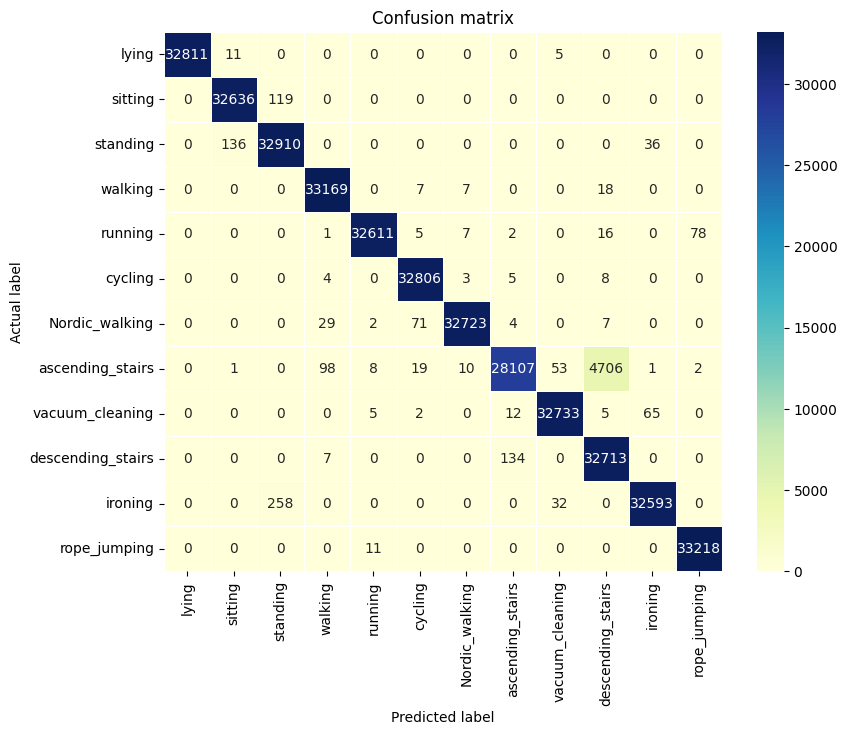

In [122]:
# create heatmap
class_labels = list(range(0,12,1))
class_labels = [inv_activity_id_mapping.get(x) for x in class_labels]
class_labels = [activity_id_dict.get(x) for x in class_labels]

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',linewidths=0.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [123]:
cnf_matrix = pd.DataFrame(cnf_matrix)

In [124]:
#Performance

recall = np.diag(cnf_matrix) / np.sum(cnf_matrix, axis = 1)
precision = np.diag(cnf_matrix) / np.sum(cnf_matrix, axis = 0)
f1_score = (2*recall*precision) / (recall+precision)

d = {'activity':class_labels, 'precision':precision, 'recall':recall, 'f1-score':f1_score}
performance = pd.DataFrame(data = d)
performance

,activity,precision,recall,f1-score
0,lying,1.000000,0.999513,0.999756
1,sitting,0.995486,0.996367,0.995926
2,standing,0.988674,0.994801,0.991728
3,walking,0.995827,0.999036,0.997429
4,running,0.999203,0.996669,0.997934
5,cycling,0.996840,0.999391,0.998114
6,Nordic_walking,0.999176,0.996559,0.997865
7,ascending_stairs,0.994445,0.851598,0.917495
8,vacuum_cleaning,0.997258,0.997288,0.997273
9,descending_stairs,0.872975,0.995708,0.930311


In [125]:
precision_mean = np.sum(performance['precision']) / performance.shape[0]
recall_mean = np.sum(performance['recall']) / performance.shape[0]
f1_mean = np.sum(performance['f1-score']) / performance.shape[0]

#print("Accuracy:   %.4f" % (correct_val / total_val))
print("Precsision: %.4f" % precision_mean)
print("Recall:     %.4f" % recall_mean)
print("F1-score:   %.4f" % f1_mean)


Precsision: 0.9862
Recall:     0.9848
F1-score:   0.9847


In [126]:
#!!! careful, dont override other models !!!

model_path = '/content/drive/My Drive/final_project/models/'


#torch.save(model.state_dict(), model_path + 'nn_64_128_64_relu_lr0_01_100e.pt')



#Load model

#model.load_state_dict(torch.load(file_path+'p2b_0.001.pt'))